#  コンテンツ
- 全周ベジエ近似についての考察
- 曲率関数
- 段階的近似

## 1. 全周ベジエ近似についての考察


ベジエ曲線は円などの閉曲線を正確に記述することはできない。（複数のセグメントに分けて区分的に近似することはできる）

また、始点、終点をどこにでも設定できるため回転不変性はないので、全周を近似するためには、人間が始点・終点を指定するか、あるいは回転不変な特徴点を基準にして始点・終点を定めざるを得ない。逆に言えば、そのような点が設定できるのであれば自動で近似可能であるとも言える。

例えば、

- 曲率最大点
- 重心から最短の輪郭点。逆に最遠の輪郭点
- 最も遠い輪郭点のペアのうちの１点

などが考えられる。

下のプログラムでは、 曲率に準じる方法として、ハリスコーナー検出 により求めたコーナを基準にして全周ベジエ近似を試みている。


## 2. 曲率関数

パラメトリック曲線の曲率は、

$$\frac{1}{R}=\frac{(x'(t)y''(t) - y'(t)x''(t))}{(x'(t)^2 + y'(t)^2)^{3/2}}$$

で表せる。ベジェ曲線もパラメトリック曲線であるので、この式が有効である。


-　[曲率・曲率半径 (curvature and radius of curvature)](http://w3e.kanazawa-it.ac.jp/math/category/kika/heimenkika/henkan-tex.cgi?target=/math/category/kika/heimenkika/curvature.html)

-　[ベジェ曲線の曲率](http://geom.web.fc2.com/geometry/bezier/curvature.html)


## 3. 段階的近似

ベジエ近似において、各サンプル点に対するパラメータが既知であれば、制御点は単純な最小自乗法で求めうる。

すなわち、、制御点座標を未知数として自乗誤差を定義し、各制御点座標を表す変数による微係数＝０という連立方程式をとけば良い。

この方程式は単純な線形方程式になるので容易に解ける。

問題はパラメータが未知であるという点である。


rdlib2 のベジエ近似関数　　**fitBezierCurveN** では、

1. 輪郭に沿って測った基準点からの距離を総距離で除した値をパラメータ推定の初期値とし、これを固定して近似曲線を求める。
2. 各サンプル点に対し、求められた近似曲線上の最寄り点のパラメータによりそのサンプル点に紐付けるパラメータを更新する。
3. 新たなパラメータを用いて誤差を定義し直し、再近似する。

２.３を紐づけパラメータの変化が十分小さくなるまで繰り返す。

という手法を取った。

この過程でベジエ近似の次数は最初から最後まで一貫して指定された次数を用いているが、別の考え方として、

1. 上の手順で２次ベジエ近似を完了する。すなわちN=2。
2. N次のベジエ近似で決まった推定パラメータを初期値として、N+1次のベジエ近似を行うl
3. 指定された次数に達するまで１つずつ次数をあげていく。

という方法も考えられる。

In [16]:
import numpy as np
import matplotlib
# matplotlib.use('Agg') # 表示しないモード。バッチ処理する場合、画像表示が多くなりすぎて　notebooke の制限で途中で止まってしまう。
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from PIL import Image
import math
import pandas as pd

from sympy import *
from sympy.abc import a,b,c
# init_session()
px,py =var('px:4'),var('py:4')
t = symbols('t')
from sympy import var
import mpmath as mp
from mpmath import findroot

from rdlib2 import *

import datetime
import time

import os

class MyBezier:
    colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628', '#f781bf']
    nextcolor = 0
    def __init__(self,bezfunc): # 初期化： インスタンス作成時に自動的に呼ばれる
        self.bezfunc = bezfunc
        
    def drawBez(self,n_samples=0,cnt=[],tpara=[],rdimg=[],cont=True):
        bezX,bezY = self.bezfunc
        self.rdimg = rdimg
        
        if n_samples==0:
            if len(cnt) != 0:
                n_samples = len(cnt)
            else:
                n_samples = len(tpara)
                
        tplins = np.linspace(0, 1, 101)
        
        if len(rdimg) > 0:
            plt.imshow(192+(cv2.cvtColor(rdimg,cv2.COLOR_GRAY2RGB)/4).astype(np.uint8))
            
        plotx = [bezX.subs(t,tp) for tp in tplins ]
        ploty = [bezY.subs(t,tp) for tp in tplins ]
        plt.plot(plotx,ploty,color = self.colors[self.nextcolor])
        
        if len(cnt) > 0:
            plt.scatter([x for [x,y] in cnt],[y for [x,y] in cnt],marker = '.')
            
        if len(tpara) > 0:
            samples = [[bezX.subs(t,i),bezY.subs(t,i)]  for i in tpara]
            plt.scatter([x for [x,y] in samples],[y for [x,y] in samples],marker = '*')
            
            if len(tpara)%2 ==0:
                (x,y)=(samples[int(len(tpara)/2)]+samples[int(len(tpara)/2)+1])/2
            else:
                (x,y)=samples[int(len(tpara)/2)+1]
            plt.scatter([x],[y],marker='o',color="red")
            
        self.nextcolor = self.nextcolor+1
        if len(self.colors) <= self.nextcolor:
            self.nextcolor = 0
            
        if cont == False:
            plt.show()

# 重心の位置を求める
'''def getCoG(img):
    _lnum, _img, cnt, cog = cv2.connectedComponentsWithStats(img)
    areamax = np.argmax(cnt[1:,4])+1 # ０番を除く面積最大値のインデックス
    c_x,c_y = np.round(cog[areamax]) # 重心の位置を丸めて答える
    # x,y,w,h,areas = cnt[areamax] # 囲む矩形の x0,y0,w,h,面積
    return c_x,c_y,cnt[areamax]
'''

def makeInitialPara(points): 
    # 初期の推定パラメータの決定
    # inf データの部分を補完する
    points = eraseinf(points)
    ## サンプル点間の差分を求める
    points1 = points[1:] #  ２つ目から後ろのサンプル点
    ds = points1-points[:-1] # サンプル点間の差分ベクトル
    la = [np.sqrt(e[0]*e[0]+e[1]*e[1]) for e in ds] # サンプル点間の直線距離のリスト
    axlength = np.sum(la) # 折れ線近似による経路長
    npoints = len(points)
    tpara0 = np.zeros(npoints,np.float32) # パラメータ格納配列
    tpara = tpara0.copy()
    tpara[0]=0.0 # 最初の点のパラメータ推定値は０とする
    for i in range(len(la)):
        tpara[i+1] = tpara[i]+la[i] # 各サンプル点での積算経路長
    tpara = tpara/axlength # 全経路長で割ってパラメータとする　（０〜１）
    return tpara
    
#  N次ベジエフィッティング
def fitBezierCurveN2(points, initialpara, precPara=0.01,N=5, openmode=False,debugmode=False):
    
    # order 次数、openmode: 両端点フリー、Falseの時は両端点固定
    # ベジエ曲線を定義するのに使うシンボルの宣言

    P = [Symbol('P' + str(i)) for i in range(N+1)]
    px = [var('px'+str(i)) for i in range(N+1)]
    py = [var('py'+str(i)) for i in range(N+1)]
    dx_ = [var('dx_'+str(i)) for i in range(N+1)]
    dy_ = [var('dy_'+str(i)) for i in range(N+1)]
 
    tpara = initialpara
    
    for i in range(N+1):
        P[i] = Matrix([px[i],py[i]]) 
    
    # いわゆる自乗誤差の一般式
    s,t= symbols('s,t')
    loss1 = (s - t)**2
    # 最小自乗法の目的関数の一般式
    def lossfunc(listA,listB):
        return sum([loss1.subs([(s,a),(t,b)]) for (a,b) in zip(listA,listB)])/2
    v = var('v')
    # N次のベジエ曲線の定義式制御点 P0~PN とパラメータ　　t　の関数として定義
    v = 1-t
    bezN = Matrix([0,0])
    for i in range(0,N+1):
        bezN = bezN + binomial(N,i)*v**(N-i)*t**i*P[i]

    #  パラメトリック曲線　linefunc 上で各サンプル点に最寄りの点のパラメータを対応づける
    def refineTparaN(pl,linefunc,npoints=50):
        (funcX,funcY) = linefunc # funcX,funcY は t の関数
        # 各サンプル点に最も近い曲線上の点のパラメータ t を求める。
        # trange = np.arange(-0.1,1.1,1/(2*npoints)) # 推定範囲は -0.1 〜　１．１ サンプル数の2倍の候補点を設定
        if openmode:
            trange0 = np.arange(-0.1,0.25,1/(4*npoints))
            trange2 = np.arange(0.75,1.1,1/(4*npoints))
            trange2 = np.r_[trange2,[1.1]]
        else:
            trange0 = np.arange(0,0.25,1/(4*npoints))
            trange2 = np.arange(0.75,1,1/(4*npoints))
            trange2 = np.r_[trange2,[1]]
        trange1 = np.arange(0.25,0.75,1/(2*npoints))
        trange = np.r_[trange0[:-1],trange1,trange2[1:]] # 最初の１/4 と最後の1/4 は近似精度が落ちるので２倍の点を用意する。
        onpoints = [[s,funcX.subs(t,s),funcY.subs(t,s)] for s in trange] # 曲線上の点
        tpara = np.zeros(len(pl),np.float32) # 新しい 推定 t パラメータのリスト用の変数のアロケート
        refineTparaR(pl,tpara,0,len(pl),0,len(onpoints),onpoints) #  ０からなので、len(pl) 番はない　len(onpoints)番もない
        return tpara

    # 範囲全体をサーチするのはかなり無駄なので、約６割ぐらいに狭める
    def srange(n,stt,end,smin,smax):
        if RPARA == 1:
            return smin,smax
        else:
            if end - stt < 3 : # 残り３点未満なら全域サーチする
                left,right = smin,smax
            else:
                srange = smax-smin
                left = smin + srange*((n-stt)/(end-stt) - RPARA/2 if (n-stt)/(end-stt) > RPARA/2 else 0)  
                left = smin+(n-stt)-1 if left < smin+(n-stt)-1 else left   # n番の左に未定がn-stt個あるので最低その分残してしておかないといけない
                right = smax - srange*((end-n)/(end-stt) - RPARA/2 if (end-n)/(end-stt) > RPARA/2 else 0)
                right = smax-(end-n) if right > smax-(end-n) else right
            left = (int(left-0.5)   if int(left-0.5) > smin else smin) # 0.5 は　RPARAとは無関係なので注意
            right = (int(right+0.5) if int(right+0.5) < smax else smax)
            return left, right
       
    #  探索範囲内での対応づけ再帰関数
    # pl 点列、(stt,end) 推定対象範囲（番号）, (smin,smax) パラメータの探索範囲         
    def refineTparaR(pl,tpara,stt,end,smin,smax,onpoints):
        nmid = int((end+stt-1)/2) # 探索対象の中央のデータを抜き出す
        px,py = points[nmid] # 中央のデータの座標
        smin1, smax1 = srange(nmid,stt,end,smin,smax) # 初期サーチ範囲を決める
        if  smin1 == smax1 and stt == end:
            nearest_i = smin1 # = smax1
        else:
            while True:
                zahyo = (np.array(onpoints[smin1:smax1]).copy())[:,1:] # onpoints リストの座標部分のみ取り出し            
                differ = zahyo - np.array([px,py]) # 差分の配列
                distance = [x*x+y*y for x,y in differ] # 自乗誤差の配列
                nearest_i = smin1+np.argmin(distance) # 誤差最小のインデックス
                if (nearest_i > smin1 and nearest_i < smax1) or nearest_i == smin or nearest_i == smax:
                    if nearest_i - smin < nmid-stt: # 小さい側の残りリソースが不足
                        nearest_i = nearest_i+(nmid-stt)-(nearest_i-smin) 
                    elif smax-nearest_i < end-nmid: # 大きい側のリソースが不足
                        nearest_i = nearest_i-(end-nmid)+(smax-nearest_i)
                    break
                if smin1==smax1:
                    print("SAME")
                if nearest_i == smax1:
                    print(">",end=="")
                    (smin1,smax1) = (smax1-1, smax1 + 3) if smax1 + 3 < smax else (smax1-1,smax)
                elif nearest_i == smin1 :
                    print("<",end="")
                    (smin1,smax1) = (smin1 - 3, smin1+1) if smin1 - 3 > smin else (smin,smin1+1)
        
        # nmid番のサンプル点に最も近い点のパラメータは、onpoints の nearest_i 番と確定
        tpara[nmid] = onpoints[nearest_i][0] # 中央点のパラメータが決定
        if nmid-stt >= 1 : # 左にまだ未処理の点があるなら処理する
            refineTparaR(pl,tpara, stt,nmid,smin,nearest_i,onpoints)
        if end-(nmid+1) >=1 : # 右にまだ未処理の点があるなら処理する
            refineTparaR(pl,tpara,nmid+1,end,nearest_i+1,smax,onpoints) 
                
    trynum = 0
    while True:
        trynum += 1
        linepoints = [bezN.subs(t,t_) for t_ in tpara] # 曲線上の点列の式表現
        linepointsX = [x  for  [x,y] in linepoints] # X座標のリスト、式表現
        linepointsY = [y  for  [x,y] in linepoints] # Y座標のリスト、式表現
        EsumX = lossfunc(listA=points[:,0],listB=linepointsX) #  X方向のずれの評価値
        EsumY = lossfunc(listA=points[:,1],listB=linepointsY) #  Y 方向のずれの評価値
        # px0,px1, px2, px3, ... py1, py2,py3 ...で偏微分
        
        if  not openmode : # 両端点を固定
            EsumX = EsumX.subs(px[-1],points[-1][0])
            EsumY = EsumY.subs(py[-1],points[-1][1])
            EsumX = EsumX.subs(px[0],points[0][0])
            EsumY = EsumY.subs(py[0],points[0][1])
        for i in range(0,N+1):
            dx_[i] = diff(EsumX,px[i])
            dy_[i] = diff(EsumY,py[i])  
 
        # 連立させて解く
        if not openmode :
            resultX = solve([dx_[i] for i in range(1,N)],[px[i] for i in range(1,N)])
            resultY = solve([dy_[i] for i in range(1,N)],[py[i] for i in range(1,N)])
        else : 
            resultX = solve([dx_[i] for i in range(N+1)],[px[i] for i in range(N+1)])
            resultY = solve([dy_[i] for i in range(N+1)],[py[i] for i in range(N+1)])
        
        if len(resultX) == 0 or len(resultY) == 0: # 方程式が解けない　非常にまれなケース
            return False,np.array([]),np.array([]),None,None,None
        
        # 解をベジエの式に代入
        if not openmode:
            bezresX = bezN[0].subs([(px[0],points[0][0]),(px[-1],points[-1][0])])
            bezresY = bezN[1].subs([(py[0],points[0][1]),(py[-1],points[-1][1])])
            for i in range(1,N):
                bezresX = bezresX.subs(px[i],resultX[px[i]])
                bezresY = bezresY.subs(py[i],resultY[py[i]])
        else: 
            bezresX = bezN[0]
            bezresY = bezN[1]           
            for i in range(0,N+1):
                bezresX = bezresX.subs(px[i],resultX[px[i]])
                bezresY = bezresY.subs(py[i],resultY[py[i]])
            
        rx,ry = resultX,resultY
        if not openmode:
            cpx = [points[0][0]]+[rx[px[i]] for i in range(1,N)]+[points[-1][0]]
            cpy = [points[0][1]]+[ry[py[i]] for i in range(1,N)]+[points[-1][1]]    
        else: # openmode
            cpx = [rx[px[i]] for i in range(N+1)]
            cpy = [ry[py[i]] for i in range(N+1)]
        
        tpara0 = tpara.copy() # 元の t の推定値
        tpara = refineTparaN(points,(bezresX,bezresY),npoints=len(points)) # 新たに推定値を求める
        
        tpara = (tpara+tpara0)/2
        
        diffpara = 0
        for i in range(len(tpara)) :
            diffpara += np.sqrt((tpara[i]-tpara0[i])**2) # 変化量の合計
        print(".",end='')
        diffpara = diffpara/len(tpara)
        if debugmode:
            print("TRY {0} diffpara {1:0.5f} : {2:0.5f}".format(trynum,diffpara*100,precPara*1.05**(0 if trynum <=5 else trynum-5)))
        if trynum <= 5:
            if diffpara < precPara/100:
                break
        else:
            if diffpara < precPara/100*1.05**(trynum-5): # 収束しない時のために、条件を徐々に緩めていく
                break
    print("o",end="")
        
    return True,np.array(cpx),np.array(cpy),bezresX,bezresY,tpara
    # cpx,cpy 制御点、bezresX,bezresY ベジエ曲線の定義式
    # tpara 制御点   

UNIT=256
def test(path,M=3,N=15,samplespans=100,precPara=0.1,debugmode=True, overwrap=False):
    
    src = cv2.imread(path,cv2.IMREAD_GRAYSCALE) # グレイで読み込み
    rdimg = getstandardShape(src, unitSize=UNIT) # 適度に平滑化した２値画像を作成 
    
    c_x,c_y,(x0,y0,w0,h0,areas) = getCoG(rdimg) # 重心とバウンディングボックスと面積
    
    _image, contours, _hierarchy = cv2.findContours(rdimg, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) # 輪郭線追跡
    cnt00 = contours[np.argmax([len(c) for c in contours])] # 最も長い輪郭

    # （平滑化した上で）尻尾の尖端座標を求める
    c_x,c_y,t_x,t_y = getCoGandTip(rdimg, showResult=True, useOldImage=True)

    # 尖端位置に半径１０の円を描き、輪郭に切れ目を入れる　（結果を目視しやすくするために半径７で半幅３の円を描くことで実質半径１０
    canvas = np.zeros_like(rdimg)
    canvas = cv2.drawContours(canvas,[cnt00],-1,255,1)
    rdCimg = cv2.circle(canvas,(int(t_x),int(t_y)),7,100,3) # 円を灰色で描く

    # 尖端に残る切れ端を取り除くため、ラベルづけして最大領域を抜き出す
    _ret,rdCimg = cv2.threshold(rdCimg,200,255,cv2.THRESH_BINARY)
    _lnum, labelimg, cnt, _cog =cv2.connectedComponentsWithStats(rdCimg)
    areamax = np.argmax(cnt[1:,4])+1 # ０番を除く面積最大値のインデックス
    rdCimg=((labelimg==areamax)*255).astype(np.uint8) # 長い輪郭だけの画像

    # 輪郭線画像の輪郭線追跡
    _, contours, hierarchy = cv2.findContours(rdCimg, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
    cnt0=contours[0] # 領域は１つしかないので０番で間違いないはず
    
    # 分岐のない線図形の輪郭は、トレースが端点から始まれば１箇所、途中からなら２箇所折り返しがある。端点と折り返し、
    # もしくは、折り返しと折り返しの間を取り出すことで、重複のない輪郭データとする
    i1 = 0
    for i in range(int(len(cnt0))-1):
        if np.all(cnt0[i-1] == cnt0[i+1]):
            # print("折り返し点",i)
            i0,i1= i1,i
    cnt0 = cnt0[i0:i1+1]
    if cnt0[0][0][0] > cnt0[-1][0][0]: # contours はかっこが２重なので注意
        cnt0 = cnt0[::-1] # もし輪郭先頭画素が末端画素より右にあれば逆順にする
    # ２重カッコを１重に変換
    cnt0 = [[x,y] for [[x,y]] in cnt0]    

    # 輪郭点を一定間隔でサンプリング して標本を10１つくる　（ぐるっと１００分割）
    cnt1 = (np.array(cnt0))[list(map(int,np.linspace(0, len(cnt0)-1,samplespans+1)))]
    #result1,cpx,cpy,bezX1,bezY1,tp = fitBezierCurveN(cnt1[:61],precPara=0.02,N=6,openmode=False,debugmode=True)
    #result2,cpx,cpy,bezX2,bezY2,tp = fitBezierCurveN(cnt1[60:],precPara=0.02,N=6,openmode=False,debugmode=True)
    #result3,cpx,cpy,bezX3,bezY3,tp = fitBezierCurveN(cnt1[30:91],precPara=0.02,N=6,openmode=False,debugmode=True)

    plt.figure(figsize=(6,6),dpi=100)
    plt.gca().invert_yaxis() 
    plt.gca().set_aspect('equal', adjustable='box') # アスペクト比を１：１に
    
    # 初期パラメータを等間隔で作成
    initpara = makeInitialPara(cnt1)
    
    print("N=",M)
    result,cpx,cpy,bezX,bezY,tpara = fitBezierCurveN2(cnt1,initialpara=initpara, precPara=precPara,N=M,openmode=False,debugmode=debugmode)

    bez = MyBezier(bezfunc=(bezX,bezY))
    # bez0.drawBez(rdimg=rdimg,n_samples=len(cnt1),cnt=cnt1,tpara=tpara,cont=(True if M<N else False))
    
    for nrank in range(M+1,N+1):
        print("N=",nrank)
        if overwrap:
            bez.drawBez(rdimg=rdimg,n_samples=len(cnt1),cnt=cnt1,tpara=tpara,cont=(True if nrank<N-1 else False))
        result,cpx,cpy,bezX,bezY,tpara = fitBezierCurveN2(cnt1,initialpara=tpara, precPara=precPara,N=nrank,openmode=False,debugmode=debugmode)
        bez = MyBezier(bezfunc=(bezX,bezY))
        bez.nextcolor = nrank % 8
        
    bez.drawBez(rdimg=rdimg,n_samples=len(cnt1),cnt=cnt1,tpara=tpara,cont=False)

# kyokuritsu # R = (x'(t)^2 + y'(t)^2)^(3/2)/(x'(t)*y''(t) - y'(t)*x''(t))

# M次からN次までの段階的近似

In [2]:
UNIT=256
def test(path,M=3,N=15,tpara = [], samplespans=100,precPara=0.1,debugmode=True,overwrap=False):
    
    src = cv2.imread(path,cv2.IMREAD_GRAYSCALE) # グレイで読み込み
    rdimg = getstandardShape(src, unitSize=UNIT) # 適度に平滑化した２値画像を作成 
    
    c_x,c_y,(x0,y0,w0,h0,areas) = getCoG(rdimg) # 重心とバウンディングボックスと面積
    
    _image, contours, _hierarchy = cv2.findContours(rdimg, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) # 輪郭線追跡
    cnt00 = contours[np.argmax([len(c) for c in contours])] # 最も長い輪郭

    # （平滑化した上で）尻尾の尖端座標を求める
    c_x,c_y,t_x,t_y = getCoGandTip(rdimg, showResult=True, useOldImage=True)

    # 尖端位置に半径１０の円を描き、輪郭に切れ目を入れる　（結果を目視しやすくするために半径７で半幅３の円を描くことで実質半径１０
    canvas = np.zeros_like(rdimg)
    canvas = cv2.drawContours(canvas,[cnt00],-1,255,1)
    rdCimg = cv2.circle(canvas,(int(t_x),int(t_y)),7,100,3) # 円を灰色で描く

    # 尖端に残る切れ端を取り除くため、ラベルづけして最大領域を抜き出す
    _ret,rdCimg = cv2.threshold(rdCimg,200,255,cv2.THRESH_BINARY)
    _lnum, labelimg, cnt, _cog =cv2.connectedComponentsWithStats(rdCimg)
    areamax = np.argmax(cnt[1:,4])+1 # ０番を除く面積最大値のインデックス
    rdCimg=((labelimg==areamax)*255).astype(np.uint8) # 長い輪郭だけの画像

    # 輪郭線画像の輪郭線追跡
    _, contours, hierarchy = cv2.findContours(rdCimg, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
    cnt0=contours[0] # 領域は１つしかないので０番で間違いないはず
    
    # 分岐のない線図形の輪郭は、トレースが端点から始まれば１箇所、途中からなら２箇所折り返しがある。端点と折り返し、
    # もしくは、折り返しと折り返しの間を取り出すことで、重複のない輪郭データとする
    i1 = 0
    for i in range(int(len(cnt0))-1):
        if np.all(cnt0[i-1] == cnt0[i+1]):
            # print("折り返し点",i)
            i0,i1= i1,i
    cnt0 = cnt0[i0:i1+1]
    if cnt0[0][0][0] > cnt0[-1][0][0]: # contours はかっこが２重なので注意
        cnt0 = cnt0[::-1] # もし輪郭先頭画素が末端画素より右にあれば逆順にする
    # ２重カッコを１重に変換
    cnt0 = [[x,y] for [[x,y]] in cnt0]    

    # 輪郭点を一定間隔でサンプリング して標本を10１つくる　（ぐるっと１００分割）
    cnt1 = (np.array(cnt0))[list(map(int,np.linspace(0, len(cnt0)-1,samplespans+1)))]
    #result1,cpx,cpy,bezX1,bezY1,tp = fitBezierCurveN(cnt1[:61],precPara=0.02,N=6,openmode=False,debugmode=True)
    #result2,cpx,cpy,bezX2,bezY2,tp = fitBezierCurveN(cnt1[60:],precPara=0.02,N=6,openmode=False,debugmode=True)
    #result3,cpx,cpy,bezX3,bezY3,tp = fitBezierCurveN(cnt1[30:91],precPara=0.02,N=6,openmode=False,debugmode=True)

    plt.figure(figsize=(6,6),dpi=100)
    plt.gca().invert_yaxis() 
    
    # 初期パラメータを等間隔で作成
    if len(tpara) == 0:
        initpara = makeInitialPara(cnt1)
    else:
        initpara = tpara
    
    print("N=",M)
    result,cpx,cpy,bezX,bezY,tpara = fitBezierCurveN2(cnt1,initialpara=initpara, precPara=precPara,N=M,openmode=False,debugmode=debugmode)

    bez = MyBezier(bezfunc=(bezX,bezY))
    # bez0.drawBez(rdimg=rdimg,n_samples=len(cnt1),cnt=cnt1,tpara=tpara,cont=(True if M<N else False))
    
    for nrank in range(M+1,N+1):
        if overwrap:
            print("Drawing",nrank-1,(True if nrank<N-1 else False))
            bez.drawBez(rdimg=rdimg,n_samples=len(cnt1),cnt=cnt1,tpara=tpara,cont=(True if nrank-1<N else False))
        print("N=",nrank)
        result,cpx,cpy,bezX,bezY,tpara = fitBezierCurveN2(cnt1,initialpara=tpara, precPara=precPara,N=nrank,openmode=False,debugmode=debugmode)
        bez = MyBezier(bezfunc=(bezX,bezY))
        bez.nextcolor = nrank % 8
        
    bez.drawBez(rdimg=rdimg,n_samples=len(cnt1),cnt=cnt1,tpara=tpara,cont=False)
    
    return tpara,bez

# kyokuritsu # R = (x'(t)^2 + y'(t)^2)^(3/2)/(x'(t)*y''(t) - y'(t)*x''(t))

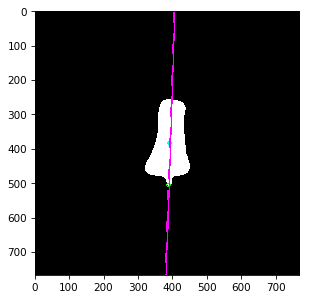


N= 2
.TRY 1 diffpara 2.25533 : 0.30000
.TRY 2 diffpara 1.40425 : 0.30000
.TRY 3 diffpara 1.04476 : 0.30000
.TRY 4 diffpara 0.80258 : 0.30000
.TRY 5 diffpara 0.62077 : 0.30000
.TRY 6 diffpara 0.50120 : 0.31500
.TRY 7 diffpara 0.42361 : 0.33075
.TRY 8 diffpara 0.36018 : 0.34729
.TRY 9 diffpara 0.30496 : 0.36465
oDrawing 2 False
N= 3
.TRY 1 diffpara 0.55712 : 0.30000
.TRY 2 diffpara 0.28390 : 0.30000
oDrawing 3 False
N= 4
.TRY 1 diffpara 0.32785 : 0.30000
.TRY 2 diffpara 0.26004 : 0.30000
o

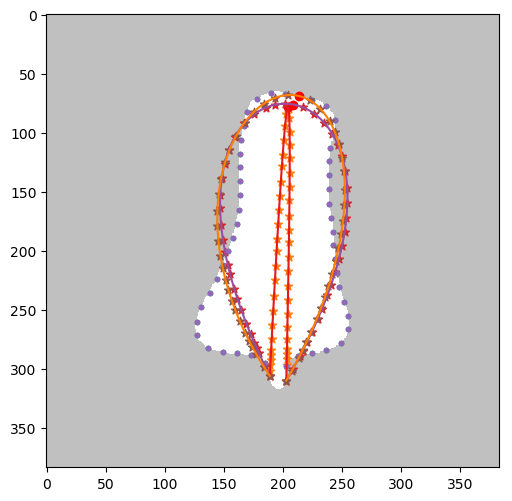

In [3]:
tpara,bez=test('シルエット/17Apically/17daruma6o06_l.jpg',samplespans=50,precPara=0.3,M=2,N=4,overwrap=True)

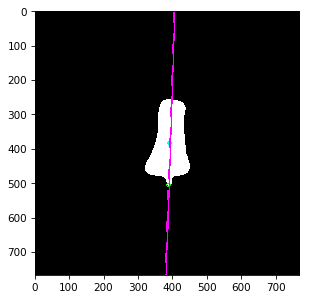

N= 5
.TRY 1 diffpara 0.41721 : 0.30000
.TRY 2 diffpara 0.29813 : 0.30000
oDrawing 5 False
N= 6
.TRY 1 diffpara 0.21490 : 0.30000
oDrawing 6 False
N= 7
.TRY 1 diffpara 0.21984 : 0.30000
o

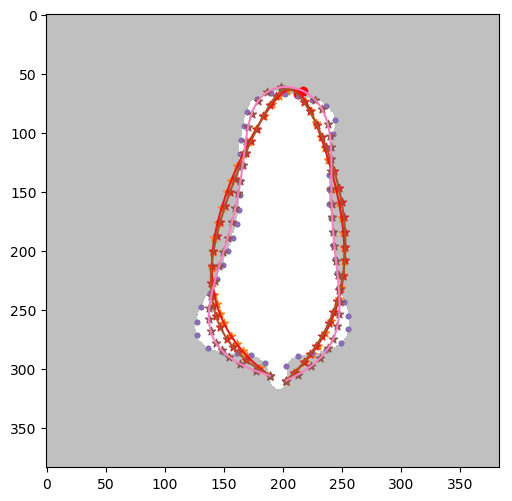

In [4]:
tpara,bez = test('シルエット/17Apically/17daruma6o06_l.jpg',samplespans=50,tpara=tpara,precPara=0.3,M=5,N=7,overwrap=True)

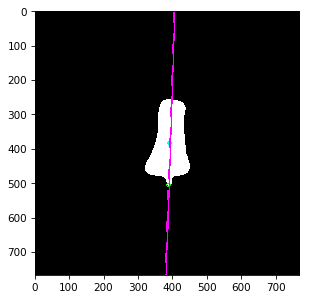

N= 8
.TRY 1 diffpara 0.16090 : 0.30000
oDrawing 8 False
N= 9
.TRY 1 diffpara 0.17930 : 0.30000
o

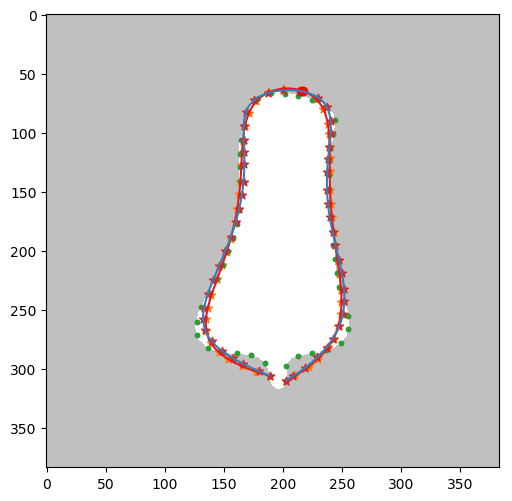

In [5]:
tpara,bez=test('シルエット/17Apically/17daruma6o06_l.jpg',samplespans=50,tpara=tpara,precPara=0.3,M=8,N=9,overwrap=True)

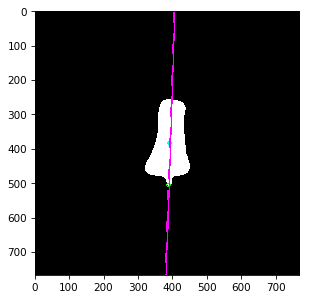

N= 10
.TRY 1 diffpara 0.20042 : 0.30000
oDrawing 10 False
N= 11
.TRY 1 diffpara 0.17825 : 0.30000
o

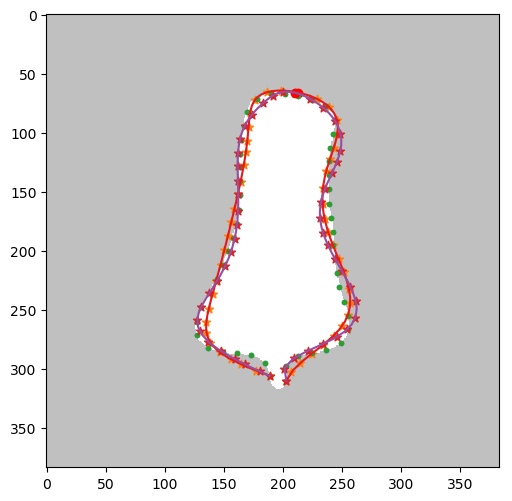

In [6]:
tpara,bez=test('シルエット/17Apically/17daruma6o06_l.jpg',samplespans=50,tpara=tpara,precPara=0.3,M=10,N=11,overwrap=True)

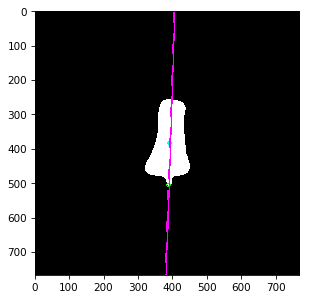

N= 12
.TRY 1 diffpara 0.11035 : 0.30000
oDrawing 12 False
N= 13
.TRY 1 diffpara 0.25825 : 0.30000
o

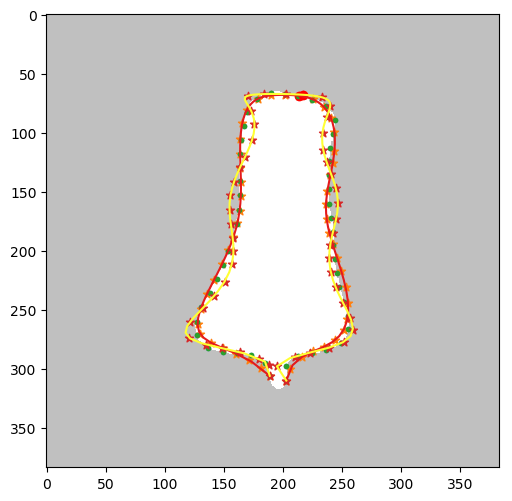

In [7]:
tpara,bez=test('シルエット/17Apically/17daruma6o06_l.jpg',samplespans=50,tpara=tpara,precPara=0.3,M=12,N=13,overwrap=True)

# 13次は鬼門？

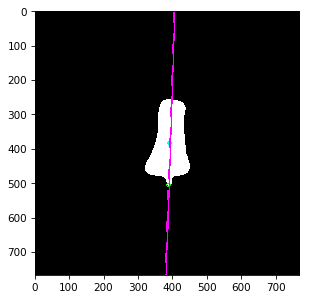

N= 14
.TRY 1 diffpara 0.11908 : 0.30000
oDrawing 14 False
N= 15
.TRY 1 diffpara 0.07815 : 0.30000
o

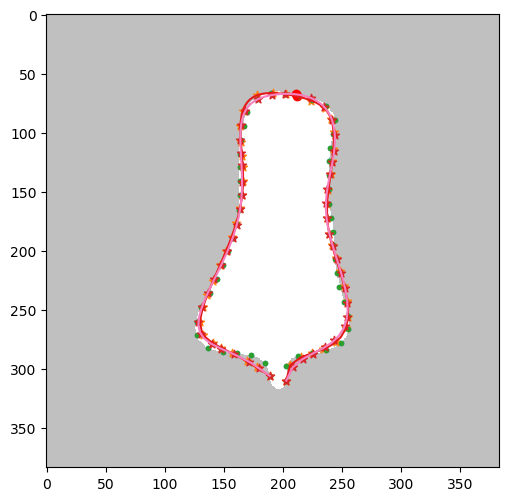

In [8]:
tpara,bez=test('シルエット/17Apically/17daruma6o06_l.jpg',samplespans=50,tpara=tpara,precPara=0.3,M=14,N=15,overwrap=True)

# 曲率計算



In [9]:
bezX,bezY = bez.bezfunc
diffX1 = diff(bezX,t)
diffY1 = diff(bezY,t)
diffX2 = diff(diffX1,t)
diffY2 = diff(diffY1,t)
R = (diffX1*diffX1+diffY1*diffY1)**(3/2)/(diffX1*diffY2-diffY1*diffX2)
Rinv = 1/R

# 曲率をパラメータの関数としてグラフ化

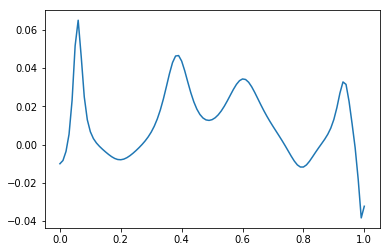

In [10]:
kyokuritsu = [Rinv.subs(t,s) for s in np.linspace(0,1,101)]
plt.plot(np.linspace(0,1,101),kyokuritsu)

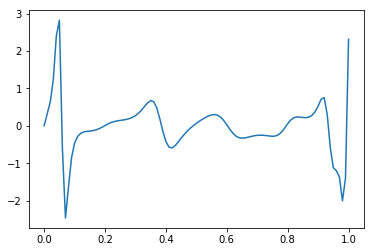

In [11]:
# 極値を求めるために曲率を微分しグラフ化
diffRinv=diff(Rinv,t)
RinvS=simplify(diffRinv)
plt.plot(np.linspace(0,1,101),[RinvS.subs(t,s) for s in np.linspace(0,1,101)])

In [12]:
# findroot 関数で求解するには　変数がxでないといけないようなので、t　を　x　に置き換え
from scipy import optimize
from sympy import lambdify
x = var('x')
RinvS.subs(t,x)

-(((3186727.21358514*x**12 + 61743088.0526275*x**11*(x - 1) + 154456408.443426*x**10*(x - 1)**2 - 881141543.392411*x**9*(x - 1)**3 - 3851318739.66575*x**8*(x - 1)**4 - 5317688148.00973*x**7*(x - 1)**5 - 3361089699.7526*x**6*(x - 1)**6 - 857673059.165976*x**5*(x - 1)**7 + 328349050.405228*x**4*(x - 1)**8 + 631626861.244584*x**3*(x - 1)**9 + 325695621.004932*x**2*(x - 1)**10 + 50652183.7167648*x*(x - 1)**11 + 1275248.21255871*(x - 1)**12)*(1436.9817286681*x**14 + 56833.2430592036*x**13*(x - 1) + 1255826.71389048*x**12*(x - 1)**2 + 6746048.12326418*x**11*(x - 1)**3 + 16490346.4526125*x**10*(x - 1)**4 + 13896532.9919754*x**9*(x - 1)**5 + 17000129.5379644*x**8*(x - 1)**6 + 35679137.6465859*x**7*(x - 1)**7 + 22305949.7609493*x**6*(x - 1)**8 - 13286882.3978584*x**5*(x - 1)**9 - 19699579.1512404*x**4*(x - 1)**10 - 6883022.19196168*x**3*(x - 1)**11 - 1203517.34041076*x**2*(x - 1)**12 - 55926.2975659664*x*(x - 1)**13 - 1445.70149369552*(x - 1)**14) - (4250848.42193784*x**12 + 109621956.923564*x*

# findroot solver 

数値解法で解を求める

https://docs.sympy.org/0.7.0/modules/mpmath/calculus/optimization.html?highlight=findroot#mpmath.findroot

In [17]:
# 曲率の高い点を７点求めてみる

mp.dps = 100
ans1 =  findroot(lambda x:RinvS.subs(t,x),0.05,solver='mnewton')
ans2 = findroot(lambda x:RinvS.subs(t,x),0.25,solver='mnewton')
ans3 = findroot(lambda x:RinvS.subs(t,x),[0.26,0.4],solver='ridder')
ans4 =  findroot(lambda x:RinvS.subs(t,x),0.42,solver='mnewton')
ans5 = findroot(lambda x:RinvS.subs(t,x),0.5)
ans6 = findroot(lambda x:RinvS.subs(t,x),0.8,solver='halley')
ans7 =  findroot(lambda x:RinvS.subs(t,x),[0.9,0.98],solver='ridder')
ans1,ans2,ans3,ans4,ans5,ans6,ans7

(mpf('0.05850141541454999'),
 mpf('0.19758397437285478'),
 mpf('0.3856515636965859'),
 mpf('0.48889538888029779'),
 mpf('0.60266648293248942'),
 mpf('0.79498710236796766'),
 mpf('0.93362935287426352'))

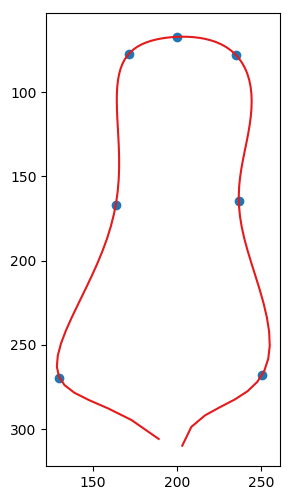

In [18]:
# 曲率の高い点をプロット
    
plt.figure(figsize=(6,6),dpi=100)
plt.gca().invert_yaxis() 
plt.gca().set_aspect('equal', adjustable='box') # アスペクト比を１：１に
bez.drawBez()
X1 = bez.bezfunc[0].subs(t,ans1)
Y1=bez.bezfunc[1].subs(t,ans1)
X2 = bez.bezfunc[0].subs(t,ans2)
Y2=bez.bezfunc[1].subs(t,ans2)
X3 = bez.bezfunc[0].subs(t,ans3)
Y3=bez.bezfunc[1].subs(t,ans3)
X4 = bez.bezfunc[0].subs(t,ans4)
Y4=bez.bezfunc[1].subs(t,ans4)
X5 = bez.bezfunc[0].subs(t,ans5)
Y5=bez.bezfunc[1].subs(t,ans5)
X6 = bez.bezfunc[0].subs(t,ans6)
Y6=bez.bezfunc[1].subs(t,ans6)
X7 = bez.bezfunc[0].subs(t,ans7)
Y7=bez.bezfunc[1].subs(t,ans7)
plt.scatter([X1,X2,X3,X4,X5,X6,X7],[Y1,Y2,Y3,Y4,Y5,Y6,Y7])